[scikit-learn.ru](https://scikit-learn.ru/6-1-pipelines-and-composite-estimators/)


#PipeLine

[Kaggle](https://www.kaggle.com/code/luxfero/lasso-regression-with-pipelines-tutorial/edit)

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Datasets/PipeLine and CrossValidation/train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Datasets/PipeLine and CrossValidation/test.csv')

X_test.iloc[:, 70:]

,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...
1454,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [3]:
from sklearn.model_selection import train_test_split

X = train.drop('SalePrice', axis=1)
y = train.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=1121218)

In [4]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

# Drop categorical columns that will not be encoded
X_train = X_train.drop(bad_label_cols, axis=1)
X_valid = X_valid.drop(bad_label_cols, axis=1)

In [5]:
X_train.describe().T.iloc[:10] # All numerical cols

,count,mean,std,min,25%,50%,75%,max
Id,1022.0,728.628180,417.491868,1.0,374.5,734.5,1082.00,1459.0
MSSubClass,1022.0,57.030333,42.861210,20.0,20.0,50.0,70.00,190.0
LotFrontage,838.0,70.190931,24.110495,21.0,60.0,70.0,80.00,313.0
LotArea,1022.0,10472.601761,8782.768055,1491.0,7560.0,9571.0,11742.50,164660.0
OverallQual,1022.0,6.071429,1.374094,1.0,5.0,6.0,7.00,10.0
OverallCond,1022.0,5.578278,1.101703,1.0,5.0,5.0,6.00,9.0
YearBuilt,1022.0,1971.221135,29.863975,1875.0,1954.0,1973.0,2000.00,2009.0
YearRemodAdd,1022.0,1984.813112,20.671520,1950.0,1966.0,1994.0,2003.75,2010.0
MasVnrArea,1015.0,101.768473,180.299391,0.0,0.0,0.0,160.00,1600.0
BsmtFinSF1,1022.0,441.294521,438.430750,0.0,0.0,381.0,707.50,2260.0


In [6]:
X_train.describe(include=np.object).T.iloc[:10] # All object cols

,count,unique,top,freq
MSZoning,1022,5,RL,809
Street,1022,2,Pave,1017
Alley,67,2,Grvl,37
LotShape,1022,4,Reg,654
LandContour,1022,4,Lvl,920
LandSlope,1022,3,Gtl,966
Neighborhood,1022,25,NAmes,156
BldgType,1022,5,1Fam,850
HouseStyle,1022,8,1Story,514
MasVnrType,1015,4,None,615


In [7]:
above_0_missing = X_train.isnull().sum() > 0

X_train.isnull().sum()[above_0_missing]

LotFrontage     184
Alley           955
MasVnrType        7
MasVnrArea        7
BsmtQual         30
BsmtCond         30
BsmtExposure     31
BsmtFinType1     30
BsmtFinType2     31
FireplaceQu     480
GarageType       58
GarageYrBlt      58
GarageFinish     58
Fence           821
dtype: int64

In [8]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 37 numerical features: 

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [9]:
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 24 categorical features: 

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'SaleCondition']


In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

In [11]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [12]:
categorical_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('one-hot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [13]:
numeric_pipeline.fit_transform(X_train.select_dtypes(include='number'))

array([[0.49451303, 0.58823529, 0.16846209, ..., 0.        , 0.36363636,
        1.        ],
       [0.63443073, 0.        , 0.16846209, ..., 0.        , 0.18181818,
        0.5       ],
       [0.53017833, 0.        , 0.16780822, ..., 0.        , 0.54545455,
        0.25      ],
       ...,
       [0.97325103, 0.        , 0.16846209, ..., 0.        , 1.        ,
        0.        ],
       [0.98902606, 0.23529412, 0.21917808, ..., 0.        , 0.27272727,
        0.75      ],
       [0.50685871, 0.23529412, 0.15068493, ..., 0.        , 0.27272727,
        0.75      ]])

In [14]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [15]:
full_processor.fit_transform(X_train)

array([[0.49451303, 0.58823529, 0.16846209, ..., 0.        , 1.        ,
        0.        ],
       [0.63443073, 0.        , 0.16846209, ..., 0.        , 0.        ,
        0.        ],
       [0.53017833, 0.        , 0.16780822, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.97325103, 0.        , 0.16846209, ..., 0.        , 1.        ,
        0.        ],
       [0.98902606, 0.23529412, 0.21917808, ..., 0.        , 1.        ,
        0.        ],
       [0.50685871, 0.23529412, 0.15068493, ..., 0.        , 1.        ,
        0.        ]])

In [16]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

lasso = Lasso(alpha=0.1)

lasso_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', lasso)
])

In [17]:
_ = lasso_pipeline.fit(X_train, y_train)

In [18]:
preds = lasso_pipeline.predict(X_valid)
mean_absolute_error(y_valid, preds)

19595.997398558986

In [19]:
lasso_pipeline.score(X_valid, y_valid)

0.7946935540535637

In [20]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__alpha': np.arange(0, 1, 0.05)}

search = GridSearchCV(lasso_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

In [21]:
print('Best score:', abs(search.best_score_))

Best score: 18074.367574589844


In [22]:
print('Best alpha:', search.best_params_)

Best alpha: {'model__alpha': 0.9500000000000001}


In [23]:
param_dict = {'model__alpha': np.arange(1, 200, 5)}

search = GridSearchCV(lasso_pipeline, param_dict, 
                      cv=10, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

In [24]:
print('Best score:', abs(search.best_score_))

Best score: 17070.552604208682


In [25]:
print('Best alpha:', search.best_params_)

Best alpha: {'model__alpha': 181}


In [26]:
lasso = Lasso(alpha=181)

final_lasso_pipe = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', lasso)
])

In [27]:
_ = final_lasso_pipe.fit(X_train, y_train)
preds = final_lasso_pipe.predict(X_valid)

mean_absolute_error(y_valid, preds)

18291.92024407007

In [28]:
final_lasso_pipe.score(X_valid, y_valid)

0.8131131130693151

#Custom Model for SkLearn and use it in PipeLines

[habr](https://habr.com/ru/company/skillfactory/blog/675876/)

In [29]:
tps_df = pd.read_csv("/content/drive/MyDrive/Datasets/tabular-playground-series-sep-2021/train.csv")
tps_df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


In [30]:
print('values and feateres shape', tps_df.shape)


# Find the number of missing values across rows
print('NaN values:\n', tps_df.isnull().sum(axis=1).sum())


values and feateres shape (957919, 120)
NaN values:
 1820782


## FunctionTransformer

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)

In [31]:
def num_missing_row(X: pd.DataFrame, y=None):
    # Calculate some metrics across rows
    num_missing = X.isnull().sum(axis=1)
    num_missing_std = X.isnull().std(axis=1)

    # Add the above series as a new feature to the df
    X["#missing"] = num_missing
    X["num_missing_std"] = num_missing_std

    return X

In [32]:
from sklearn.preprocessing import FunctionTransformer

num_missing_estimator = FunctionTransformer(num_missing_row)

In [33]:
# Check number of columns before
print(f"Number of features before preprocessing: {len(tps_df.columns)}")

# Apply the custom estimator
tps_df = num_missing_estimator.transform(tps_df)
print(f"Number of features after preprocessing: {len(tps_df.columns)}")


Number of features before preprocessing: 120
Number of features after preprocessing: 122


### Pattern

In [34]:
# The first argument is Data!
def custom_function(X, y=None):
    ...

# We can add iverse function to transformer
def inverse_of_custom(X, y=None):
    ...

estimator = FunctionTransformer(func=custom_function, inverse_func=inverse_of_custom)


## CustomTransformer

In [35]:
class CustomPowerTransformer(BaseEstimator, TransformerMixin):
    """This class adds "1" to the data and use PowerTransformer.
    If we don't do it, we can get the bug if at least one value of data was zero."""
    def __init__(self):
        self._estimator = PowerTransformer()

    def fit(self, X, y=None):
        X_copy = np.copy(X) + 1
        self._estimator.fit(X_copy)

        return self

    def transform(self, X):
        X_copy = np.copy(X) + 1

        return self._estimator.transform(X_copy)

    def inverse_transform(self, X):
        X_reversed = self._estimator.inverse_transform(np.copy(X))

        return X_reversed - 1

### Result

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb

xgb_pipe = make_pipeline(
    FunctionTransformer(num_missing_row),
    SimpleImputer(strategy="constant", fill_value=-99999),
    CustomPowerTransformer(),
    xgb.XGBClassifier(
        n_estimators=1000, tree_method="gpu_hist", objective="binary:logistic"
    ),
)

X, y = tps_df.drop("claim", axis=1), tps_df[["claim"]].values.flatten()
split = train_test_split(X, y, test_size=0.33, random_state=1121218)
X_train, X_test, y_train, y_test = split
xgb_pipe.fit(X_train, y_train)
preds = xgb_pipe.predict_proba(X_test)

roc_auc_score(y_test, preds[:, 1])

0.7986947630947118

### Pattern

In [37]:
class MyTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self):

    return self
  
  def transform(self):
    pass
  
  def inverse_tarnsform(self):
    pass

#OneHotEncoder

In [38]:
X = np.array([["a"] * 5 + ["b"] * 20 + ["c"] * 10 + ["d"] * 3], dtype=object).T

ohe = OneHotEncoder(max_categories=4, sparse_output=False).fit(X)
print('Our column:\n', np.array([["a"], ["c"]]))
print('\nResulf for "a", "b", "c", "d" categories:')
ohe.transform([["a"], ["c"]])


Our column:
 [['a']
 ['c']]

Resulf for "a", "b", "c", "d" categories:


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]])

# PowerTransformer

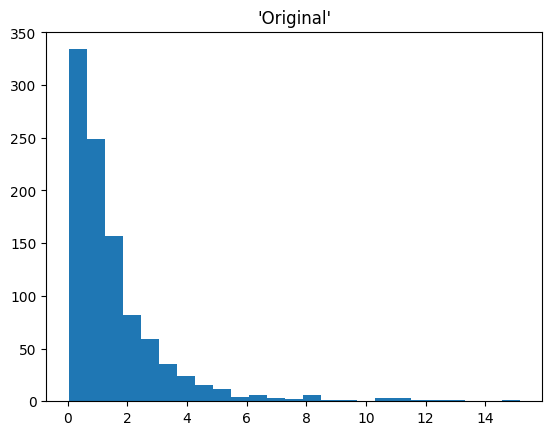

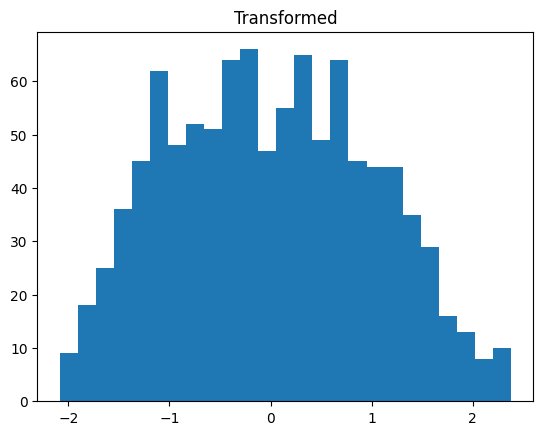

In [16]:
# demonstration of the power transform on data with a skew
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt 

# generate gaussian data sample
data = randn(1000)



# add a skew to the data distribution
data = exp(data)

# histogram of the raw data with a skew
fig, ax = plt.subplots()
ax.set_title("'Original'")
ax.hist(data, bins=25)
plt.show()



# reshape data to have rows and columns
data = data.reshape((len(data),1))

# power transform the raw data
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans = power.fit_transform(data)

# histogram of the transformed data
fig1, ax1 = plt.subplots()
ax1.hist(data_trans, bins=25)
ax1.set_title("Transformed")
plt.show()